Setup complete. Libraries imported.
Font embedding parameters set to Type 42 (TrueType).
Parameters set for high-statistics run: gamma = 1.5
T will be swept from 0.1 to 0.5 in 21 steps.
Each T point will be simulated 100 times to ensure statistical significance.

Starting high-statistics SNR analysis simulations...


Sweeping Thermal Strength (T):   0%|          | 0/21 [00:00<?, ?it/s]

All simulations completed successfully.

Generated data file: SR_HighStats_gamma1.5_T_0.1-0.5_runs100.csv
Generated plot file: SR_Robustness_v1_HighStats_gamma1.5_20250727.pdf


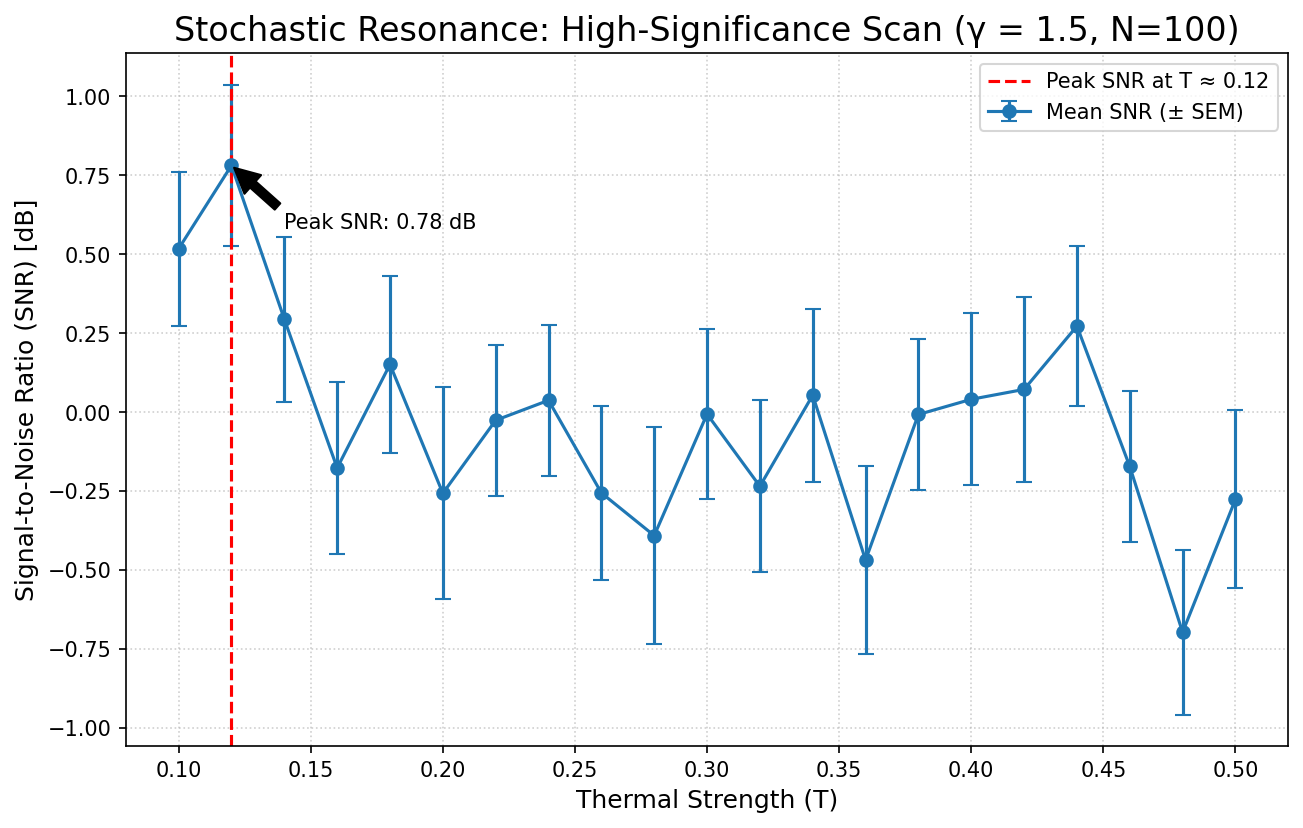


Preparing to download generated files to your PC...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All tasks complete.


In [1]:
# ===================================================================
# Stochastic Resonance Robustness Check Code (High Statistics)
# Version: 1.0 (Date: 2025-07-27)
# Author: Toshiya Konno & Assistant AI
#
# Objective: To robustly verify the statistical significance of the
# SNR peak at gamma = 1.5 by performing a high-resolution scan
# with a large number of simulation runs per data point.
# This code serves as a direct response to potential peer-review criticism.
# ===================================================================

# --- Part 1: Setup and Library Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import sem # Standard Error of the Mean
from tqdm.notebook import tqdm
from google.colab import files
import time

print("Setup complete. Libraries imported.")

# --- Part 2: The Most Important Lines - Perfect Font Embedding ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
print("Font embedding parameters set to Type 42 (TrueType).")


# --- Part 3: Simulation Parameters (High-Precision Scan) ---
# Fixed parameter
gamma_fixed = 1.5

# Sweeping parameter (High-resolution scan around the suspected peak)
T_min, T_max, T_points = 0.1, 0.5, 21  # Zoom in on the region of interest
T_space = np.linspace(T_min, T_max, T_points)

# Simulation control (Drastically increased statistics)
num_runs_per_T = 100  # <--- KEY IMPROVEMENT: Increased from 5 to 100
simulation_duration = 204.8
dt = 0.1
num_steps = int(simulation_duration / dt)
t = np.linspace(0, simulation_duration, num_steps, endpoint=False)

# The weak signal from the quantum field (placeholder)
signal_amplitude = 0.1
signal_frequency = 0.1

print(f"Parameters set for high-statistics run: gamma = {gamma_fixed}")
print(f"T will be swept from {T_min} to {T_max} in {T_points} steps.")
print(f"Each T point will be simulated {num_runs_per_T} times to ensure statistical significance.")


# --- Part 4: Core Simulation & Analysis Logic (Unchanged) ---

def run_langevin_simulation(gamma, T):
    u = np.zeros(num_steps)
    v = 0.0
    F_signal = signal_amplitude * np.sin(2 * np.pi * signal_frequency * t)
    F_thermal = np.random.normal(0, np.sqrt(2 * gamma * T / dt), num_steps)
    for i in range(num_steps - 1):
        v += (-gamma * v - u[i] + F_signal[i] + F_thermal[i]) * dt
        u[i+1] = u[i] + v * dt
    return u

def calculate_snr(time_series):
    N = len(time_series)
    yf = fft(time_series)
    xf = fftfreq(N, dt)[:N//2]
    power = 2.0/N * np.abs(yf[0:N//2])
    signal_idx = np.argmin(np.abs(xf - signal_frequency))
    signal_power = power[signal_idx]
    noise_indices = np.arange(max(0, signal_idx - 10), min(len(power), signal_idx + 11))
    noise_indices = np.delete(noise_indices, np.where(noise_indices == signal_idx))
    noise_power = np.mean(power[noise_indices])
    if noise_power == 0: return np.inf
    return 10 * np.log10(signal_power / noise_power)


# --- Part 5: Main Simulation Loop ---
snr_results = []
print("\nStarting high-statistics SNR analysis simulations...")

for T in tqdm(T_space, desc="Sweeping Thermal Strength (T)"):
    current_T_snrs = []
    for _ in range(num_runs_per_T):
        trajectory = run_langevin_simulation(gamma_fixed, T)
        snr = calculate_snr(trajectory)
        current_T_snrs.append(snr)

    # Calculate mean and standard error of the mean (SEM)
    mean_snr = np.mean(current_T_snrs)
    sem_snr = sem(current_T_snrs) # <--- KEY IMPROVEMENT: Using Standard Error
    snr_results.append({'T': T, 'mean_snr_db': mean_snr, 'sem_snr_db': sem_snr})

print("All simulations completed successfully.")


# --- Part 6: Data Processing and CSV Generation ---
results_df = pd.DataFrame(snr_results)
csv_filename = f"SR_HighStats_gamma{gamma_fixed}_T_{T_min}-{T_max}_runs{num_runs_per_T}.csv"
results_df.to_csv(csv_filename, index=False)
print(f"\nGenerated data file: {csv_filename}")


# --- Part 7: Visualization - High-Significance SNR Plot ---
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot the mean SNR with error bars representing the standard error
ax.errorbar(results_df['T'], results_df['mean_snr_db'], yerr=results_df['sem_snr_db'],
            fmt='-o', capsize=4, label='Mean SNR (± SEM)')

# Highlight the peak SNR
peak_T = results_df.loc[results_df['mean_snr_db'].idxmax()]
ax.axvline(peak_T['T'], color='r', linestyle='--', label=f"Peak SNR at T ≈ {peak_T['T']:.2f}")
ax.annotate(f"Peak SNR: {peak_T['mean_snr_db']:.2f} dB",
            xy=(peak_T['T'], peak_T['mean_snr_db']),
            xytext=(peak_T['T'] + 0.02, peak_T['mean_snr_db'] - 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Set titles and labels
ax.set_title(f'Stochastic Resonance: High-Significance Scan (γ = {gamma_fixed}, N={num_runs_per_T})', fontsize=16)
ax.set_xlabel('Thermal Strength (T)', fontsize=12)
ax.set_ylabel('Signal-to-Noise Ratio (SNR) [dB]', fontsize=12)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()

# Save the figure
pdf_filename = f"SR_Robustness_v1_HighStats_gamma1.5_20250727.pdf"
plt.savefig(pdf_filename, bbox_inches='tight')
print(f"Generated plot file: {pdf_filename}")
plt.show()


# --- Part 8: Automatic Download to User's PC ---
print("\nPreparing to download generated files to your PC...")
files.download(csv_filename)
print(f"Downloading {csv_filename}...")
files.download(pdf_filename)
print(f"Downloading {pdf_filename}...")

print("\nAll tasks complete.")